### Capstone - Final Project
### Lawrence Huang
##### Instructions
Create a new notebook and perform each of the following tasks and answer the related questions:

1. Build a simple neural networks model
2. Build a DNN model
3. Build a RNN model
4. Summarize your findings with examples.  Explain what the manufacturer should focus on to optimize the diaper manufacturing process.

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall, TruePositives
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


##### Data prepration 

In [2]:
# load data: SECOM manufacturing Data Set from UCI Machine Learning Repository
filename_features = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data'
df = pd.read_csv(filename_features, header=None, sep=' ')
filename_label = 'http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data'
df_label = pd.read_csv(filename_label, header=None, sep= ' ', usecols=[0]) # don't need label timestamp

# merge data: add label to features
df['label'] = df_label

# preview data
print('dataset shape:{}'.format(df.shape))
df.head()

dataset shape:(1567, 591)


,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,label
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [3]:
# identify zero variance columns with constant/single value 
cols_zero_var = df.loc[:, df.nunique()==1].columns.values
print('Columns with single value:\n{}'.format(cols_zero_var))
print('\n# columns with single value: {}'.format(len(cols_zero_var)))
# drop zero variance columns with constant/single value 
df.drop(cols_zero_var, axis=1, inplace=True)

Columns with single value:
[5 13 42 49 52 69 97 141 149 178 179 186 189 190 191 192 193 194 226 229
 230 231 232 233 234 235 236 237 240 241 242 243 256 257 258 259 260 261
 262 263 264 265 266 276 284 313 314 315 322 325 326 327 328 329 330 364
 369 370 371 372 373 374 375 378 379 380 381 394 395 396 397 398 399 400
 401 402 403 404 414 422 449 450 451 458 461 462 463 464 465 466 481 498
 501 502 503 504 505 506 507 508 509 512 513 514 515 528 529 530 531 532
 533 534 535 536 537 538]

# columns with single value: 116


In [4]:
# handle null/missing values
# examine data type: all numeric
print('data type:')
print(df.dtypes.value_counts())

# number of missing values: some columns are missing > 90% of values
num_missing = df.isna().sum()
print('\n# missing values/ # of columns:')
print(num_missing.value_counts().sort_index())

data type:
float64    474
int64        1
dtype: int64

# missing values/ # of columns:
0       53
1       80
2       84
3       20
4        9
5        3
6       57
7       20
8       12
9       15
10       4
12       4
14      16
24      38
51       8
260     12
273      8
715      4
794      4
949      4
1018    12
1341     4
1429     4
dtype: int64


In [5]:
# drop columns missing >50%
cols_excess_missing = num_missing[num_missing>df.shape[0]/2].index.to_list()
print('\nColumns with >50% missing values:\n{}'.format(cols_excess_missing))
print('\n# columns with >50% missing values: {}'.format(len(cols_excess_missing)))
df.drop(cols_excess_missing, axis=1, inplace=True)


Columns with >50% missing values:
[72, 73, 85, 109, 110, 111, 157, 158, 220, 244, 245, 246, 292, 293, 345, 346, 358, 382, 383, 384, 492, 516, 517, 518, 578, 579, 580, 581]

# columns with >50% missing values: 28


In [6]:
# impute other columns with missing values
# strategy: fill with median or 0. Trying median here.
print('# missing values before imputation: {}'.format(df.isna().sum().sum()))
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
# imputer = SimpleImputer(missing_values=np.nan, strategy='constant') # fill with 0
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
print('# missing values after imputation: {}'.format(df.isna().sum().sum()))

# missing values before imputation: 10868
# missing values after imputation: 0


In [7]:
# find columns with near-zero variance, with conditions 1 and 2:
# 1. few (<10%) unique values relative to the number of samples 
# 2. large ratio (>19, or >95:5%) of the frequency of the most common value to the frequency of the second most common value
top2 = (df.apply(lambda x: pd.Series(x.value_counts().values[:2]))).T
cols_nzv = df.columns[(df.nunique()/df.shape[0]<0.1) & (top2[0]/top2[1]>19)].to_list()
print('columns with near-zero variance:\n{}'.format(cols_nzv))
print('\n# columns with near-zero variance: {}'.format(len(cols_nzv)))
# drop columns with near-zero variance
df.drop(cols_nzv, axis=1, inplace=True)

columns with near-zero variance:
[74, 114, 206, 209, 249, 342, 347, 387, 478, 521, 542]

# columns with near-zero variance: 11


In [8]:
# change label to binary
df['label'].replace({-1:0}, inplace=True)
# df['label'] = df['label'].astype(int)

In [9]:
# view cleaned and preprocessed dataframe
print('dataset shape:{}'.format(df.shape))
df.head()

dataset shape:(1567, 436)


,0,1,2,3,4,6,7,8,9,10,...,577,582,583,584,585,586,587,588,589,label
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,0.1242,1.5005,0.0162,-0.0034,...,14.9509,0.5005,0.0118,0.0035,2.3630,0.0205,0.0148,0.0046,71.9005,0.0
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.4966,-0.0005,-0.0148,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0.0
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,1.4436,0.0041,0.0013,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1.0
3,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,0.1217,1.4882,-0.0124,-0.0033,...,8.5831,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0.0
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.5031,-0.0031,-0.0072,...,10.9698,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0.0


In [10]:
# train/test split
# stratify to ensure minority class representation in both sets
y = df['label'] # label
X = df.loc[:, ~df.columns.isin(['label'])] # features, start with all but the target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=8)
# print('features:\n{}'.format(X.columns.values))
print('\n# features after preprocessing: {}'.format(len(X.columns.values)))


# features after preprocessing: 435


In [11]:
# normalize data (z-score)
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

##### Handle class imbalance problem

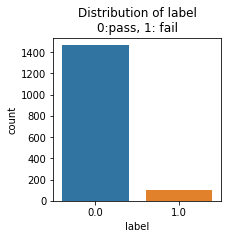

fail rate: 6.6%


In [12]:
# plot distribution of label; check for imbalanced classes
fig, ax = plt.subplots(figsize=(3,3))
sns.countplot(x='label', data=df, ax=ax)
plt.title('Distribution of label\n0:pass, 1: fail')
plt.show()
print('fail rate: {:.1f}%'.format(100*df['label'].value_counts()[1]/len(df['label'])))

In [13]:
# SMOTE was used to oversample the minority class
# By oversampling only on the training data, none of the information in the test data was being used to create synthetic observations. 
# Therefore, no information will bleed from training to testing.  
sm = SMOTE(random_state=1) # sampling strategy = resample all classes but the majority class
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
X_train_res = pd.DataFrame(data=X_train_res, columns=X_train.columns)
y_train_res = pd.Series(y_train_res)

print('\nLabel counts before SMOTE:')
print(y_train.value_counts())
print('\nLabel counts after SMOTE:')
print(y_train_res.value_counts())


Label counts before SMOTE:
0.0    1170
1.0      83
Name: label, dtype: int64

Label counts after SMOTE:
1.0    1170
0.0    1170
dtype: int64


##### Reduce dimensionality of data by selecting k best features based on ANOVA F-value (k=20)
This approach was used in previous Milestones and worked well

In [14]:
# select k best features based on ANOVA F-value
selector = SelectKBest(score_func=f_classif, k=20).fit(X_train_res, y_train_res) 
# selected features
f_cols = X_train_res.columns[selector.get_support()].to_list()
print('Selected features:\n{}'.format(f_cols))
print('\n# selected features: {}'.format(len(f_cols)))
X_train_f = pd.DataFrame(selector.transform(X_train_res), columns=f_cols)
X_test_f = pd.DataFrame(selector.transform(X_test), columns=f_cols)

Selected features:
[14, 28, 59, 70, 78, 79, 103, 121, 122, 124, 125, 127, 129, 130, 183, 247, 280, 319, 455, 510]

# selected features: 20


In [15]:
# view X_train with selected features
X_train_f.head()

,14,28,59,70,78,79,103,121,122,124,125,127,129,130,183,247,280,319,455,510
0,0.723331,1.191150,0.013310,-0.342665,0.582002,-1.636702,0.404934,-0.161772,-1.230782,-0.211832,-1.553425,-1.096585,1.270242,1.200234,0.135272,-0.280292,0.101881,0.286488,0.171658,-0.322310
1,-1.670999,0.603577,-0.976181,-0.144333,0.260633,-1.217875,-1.475459,0.141975,-0.480673,-0.827056,0.019102,-0.797241,-2.014426,0.783333,-0.118446,-0.280292,0.013117,-0.019255,-0.130273,-0.871967
2,0.406570,0.002960,0.149455,0.659427,-0.473924,0.871899,0.177990,0.648221,-0.405774,0.667060,-0.883080,-0.466545,0.496893,0.368848,0.490881,-0.581559,0.264616,0.296958,0.456769,0.679835
3,-1.168401,0.854941,-0.198924,0.613042,0.283588,-0.825224,-0.438001,-0.161772,-0.978137,-0.387610,-1.704439,-0.800227,1.618131,0.928342,-1.200428,-0.474658,0.412556,-1.396581,-1.234024,-0.499444
4,0.016984,0.972455,-0.288622,-0.104913,0.145859,-0.550369,-0.891889,0.648221,-1.212896,-0.123943,-0.349570,-1.356365,-1.667028,0.307219,0.527683,-0.280292,0.486526,0.575800,0.567785,-0.620655


##### Common model parameters

In [16]:
# set batch size, number of epochs, input dimensions
batch_size = 32
epochs = 50
# input_dim = X_train_res.shape[1] # use all features
input_dim = X_train_f.shape[1] # use 20 features selected by ANOVA F-value

# add true positives as metric to identify faulty products
metrics = [Recall(name='recall'), TruePositives(name='tp')]

# callback for early stopping, monitor validation loss
cb_loss = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]

# function to plot training/validation results
def plot_results(xx):
    fig, axs = plt.subplots(1,2)
    axs[0].plot(range(1,len(xx.history['loss'])+1), xx.history['loss'], 'o-', label='training')
    axs[0].plot(range(1,len(xx.history['val_loss'])+1), xx.history['val_loss'], 'o-', label='validation')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[1].plot(range(1,len(xx.history['recall'])+1), xx.history['recall'], 'o-', label='training')
    axs[1].plot(range(1,len(xx.history['val_recall'])+1), xx.history['val_recall'], 'o-', label='validation')
    axs[1].set_title('Class 1 Recall')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Recall')
    axs[1].set_ylim(-0.05, 1.05)
    axs[1].legend()
    fig.tight_layout()
    plt.show()

##### 1. Build a simple neural networks model
Build the simplest model with 1 input layer and 1 output layer

In [17]:
# construct model
model1 = Sequential()
model1.add(Dense(1, activation='sigmoid', input_shape=(input_dim, )))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
print(model1.summary())

history1 = model1.fit(X_train_f, y_train_res, batch_size=batch_size, epochs=epochs,
                      validation_data=(X_test_f, y_test), callbacks=cb_loss)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
None
Train on 2340 samples, validate on 314 samples
Epoch 1/50
2340/2340 [==============================] - 0s 86us/sample - loss: 0.8121 - recall: 0.5111 - tp: 598.0000 - val_loss: 0.8084 - val_recall: 0.7143 - val_tp: 15.0000
Epoch 2/50
2340/2340 [==============================] - 0s 27us/sample - loss: 0.7230 - recall: 0.6573 - tp: 769.0000 - val_loss: 0.7801 - val_recall: 0.8571 - val_tp: 18.0000
Epoch 3/50
2340/2340 [==============================] - 0s 26us/sample - loss: 0.6728 - recall: 0.7274 - tp: 851.0000 - val_loss: 0.7513 - val_recall: 0.8571 - val_tp: 18.0000
Epoch 4/50
2340/2340 [==============================] - 0s 26us/sample - l

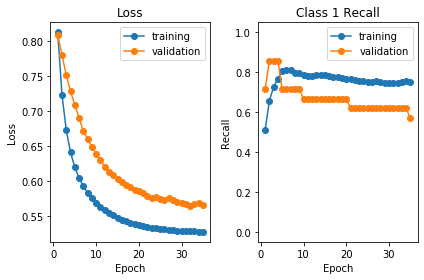

314/314 [==============================] - 0s 22us/sample - loss: 0.5649 - recall: 0.6190 - tp: 13.0000

Test loss: 0.565
Class 1 recall: 0.62
True positives: 13


In [18]:
# plot training/validation loss and recall
plot_results(history1)

# test accuracy after restoring best weights
loss1, recall1, tp1 = model1.evaluate(X_test_f, y_test, batch_size=batch_size)
print('\nTest loss: {:.3f}\nClass 1 recall: {:.2f}\nTrue positives: {:.0f}'.format(loss1, recall1, tp1))

In [19]:
# evaluate model using confusion matrix-derived metrics
y_pred1 = model1.predict_classes(X_test_f)
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred1)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred1).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred1))


Confusion Matrix:
[[206  87]
 [  8  13]]

TP, TN, FP, FN: 13 , 206 , 87 , 8

Classification report:
              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81       293
         1.0       0.13      0.62      0.21        21

    accuracy                           0.70       314
   macro avg       0.55      0.66      0.51       314
weighted avg       0.91      0.70      0.77       314



##### 2. Build a DNN model

In [20]:
# construct model
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=(input_dim, ))) 
model2.add(Dense(8, activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
print(model2.summary())

history2 = model2.fit(X_train_f, y_train_res, batch_size=batch_size, epochs=epochs,
                      validation_data=(X_test_f, y_test), callbacks=cb_loss)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1344      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,873
Trainable params: 1,873
Non-trainable params: 0
_________________________________________________________________
None
Train on 2340 samples, validate on 314 samples
Epoch 1/50
2340/2340 [==============================] - 0s 114us/sample - loss: 0.6082 - recall: 0.7068 - tp: 827.0000 - val_loss: 0.4963 - val_recall: 0.3333 - val_tp: 7.0000
Epoch 2/50
2340/2340 [

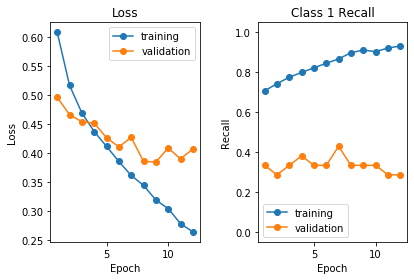

314/314 [==============================] - 0s 26us/sample - loss: 0.3846 - recall: 0.3333 - tp: 7.0000

Test loss: 0.385
Class 1 recall: 0.33
True positives: 7


In [21]:
# plot training/validation loss and recall
plot_results(history2)

# test results after restoring best weights
loss2, recall2, tp2 = model2.evaluate(X_test_f, y_test, batch_size=batch_size)
print('\nTest loss: {:.3f}\nClass 1 recall: {:.2f}\nTrue positives: {:.0f}'.format(loss2, recall2, tp2))

In [22]:
# evaluate model using confusion matrix-derived metrics
y_pred2 = model2.predict_classes(X_test_f)
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred2)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred2).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred2))


Confusion Matrix:
[[254  39]
 [ 14   7]]

TP, TN, FP, FN: 7 , 254 , 39 , 14

Classification report:
              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91       293
         1.0       0.15      0.33      0.21        21

    accuracy                           0.83       314
   macro avg       0.55      0.60      0.56       314
weighted avg       0.89      0.83      0.86       314



##### 3. Build a RNN model

<ul><li>The dataset does not have an obvious sequence structure</li>
    <li>Although there is a timestamp, the timestep between observations are variable, not constant (e.g. using day as timestep, there are one to many observations per day, as shown below)</li>
    <li>The features could be considered a sequence, if the output is dependent on the order of the columns/features. However, feature selection was applied, reducing dimensionality and also potentially altering the relationships between columns/features, if any. A workaround could be to use all features</li>
    </ul>
    
#### The following will be tested:
<ul>
    <li>Restructure data as (samples, timestep=1, features)</li>
    <li>Restructure data as (samples, timestep=#features, features=1), with 435 features after preprocessing, assuming features are an ordered sequence</li>
    <li>Restructure data as (samples, timestep=#features, features=1), with 20 selected features, assuming features are an ordered sequence</li>
    </ul>

In [23]:
# examime timestamp of the dataset
timestamp = pd.read_csv(filename_label, header=None, sep= ' ', usecols=[1]) # get label timestamp
timestamp = pd.to_datetime(timestamp[1], format='%d/%m/%Y %H:%M:%S')
print('Timestamp is monotonic? {}'.format(timestamp.is_monotonic))

# how many observations per timeframe (e.g. day)
days = pd.DataFrame(timestamp.dt.date)
testdf = pd.DataFrame(df['label'].values, index=days[1])
daily_obs = testdf.groupby(testdf.index).count()
print('Number of daily observations range from {:.0f} to {:.0f}'.format(daily_obs.describe()[0]['min'], daily_obs.describe()[0]['max']))

Timestamp is monotonic? True
Number of daily observations range from 1 to 62


##### 1: Try restructuring data as (samples, timestep=1, features) for use in RNN model
Evaluate results against previous models that use the same feature set of 20 features

In [24]:
# restructure data in (samples, timesteps=1, features=features) for RNN/LSTM
X_train_lstm = X_train_f.values.reshape(X_train_f.shape[0], 1, X_train_f.shape[1])
y_train_lstm = y_train_res.values.reshape(y_train_res.shape[0], 1, 1)
X_test_lstm = X_test_f.values.reshape(X_test_f.shape[0], 1, X_test_f.shape[1])
y_test_lstm = y_test.values.reshape(y_test.shape[0], 1, 1)

In [25]:
# construct model
model3 = Sequential()
model3.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=False))
model3.add(Dense(8))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
print(model3.summary())

history3 = model3.fit(X_train_lstm, y_train_lstm, batch_size=batch_size, epochs=epochs,
                      validation_data=(X_test_lstm, y_test_lstm), callbacks=cb_loss)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                21760     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 22,289
Trainable params: 22,289
Non-trainable params: 0
_________________________________________________________________
None
Train on 2340 samples, validate on 314 samples
Epoch 1/50
2340/2340 [==============================] - 3s 1ms/sample - loss: 0.6078 - accuracy: 0.6675 - val_loss: 0.6243 - val_accuracy: 0.6178
Epoch 2/50
2340/2340 [==============================] - 0s 66us/sample - loss: 0.5119 - accuracy: 0.7385 - val_loss: 0.5384 - val_accuracy: 0.6943
Epoch 3/50
2340/2340 [=============

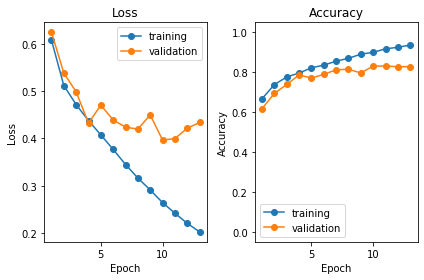


Test loss: 0.397


In [26]:
# function to plot training/validation loss and accuracy
def plot_loss_acc(xx):
    fig, axs = plt.subplots(1,2)
    axs[0].plot(range(1,len(xx.history['loss'])+1), xx.history['loss'], 'o-', label='training')
    axs[0].plot(range(1,len(xx.history['val_loss'])+1), xx.history['val_loss'], 'o-', label='validation')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[1].plot(range(1,len(xx.history['accuracy'])+1), xx.history['accuracy'], 'o-', label='training')
    axs[1].plot(range(1,len(xx.history['val_accuracy'])+1), xx.history['val_accuracy'], 'o-', label='validation')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_ylim(-0.05, 1.05)
    axs[1].legend()
    fig.tight_layout()
    plt.show()
    
# plot training/validation loss and accuracy
plot_loss_acc(history3)

# test results after restoring best weights
loss3 = model3.evaluate(X_test_lstm, y_test_lstm, batch_size=batch_size, verbose=0)
print('\nTest loss: {:.3f}'.format(loss3[0]))

In [27]:
# evaluate model using confusion matrix-derived metrics
y_pred3 = model3.predict_classes(X_test_lstm)
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred3)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred3).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred3))


Confusion Matrix:
[[254  39]
 [ 14   7]]

TP, TN, FP, FN: 7 , 254 , 39 , 14

Classification report:
              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91       293
         1.0       0.15      0.33      0.21        21

    accuracy                           0.83       314
   macro avg       0.55      0.60      0.56       314
weighted avg       0.89      0.83      0.86       314



##### 2: Try restructuring data as (samples, timestep=#features, features=1) for use in RNN model<br>(i.e. using features as a ordered sequence)

#### First, try using all 435 features after preprocessing

In [28]:
# restructure data in (samples, timesteps=features, features=1) for RNN/LSTM
# use 435 features
X_train_lstm2 = X_train_res.values.reshape(X_train_res.shape[0], X_train_res.shape[1], 1)
y_train_lstm2 = y_train_res.values.reshape(y_train_res.shape[0], 1, 1)
X_test_lstm2 = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test_lstm2 = y_test.values.reshape(y_test.shape[0], 1, 1)

In [29]:
# construct model
model4 = Sequential()
model4.add(LSTM(64, input_shape=(X_train_lstm2.shape[1], X_train_lstm2.shape[2]), return_sequences=False))
model4.add(Dense(8))
model4.add(Dense(1, activation='sigmoid'))
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
print(model4.summary())

history4 = model4.fit(X_train_lstm2, y_train_lstm2, batch_size=batch_size, epochs=epochs,
                      validation_data=(X_test_lstm2, y_test_lstm2), callbacks=cb_loss)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________
None
Train on 2340 samples, validate on 314 samples
Epoch 1/50
2340/2340 [==============================] - 15s 6ms/sample - loss: 0.6815 - accuracy: 0.5594 - val_loss: 0.6551 - val_accuracy: 0.5318
Epoch 2/50
2340/2340 [==============================] - 12s 5ms/sample - loss: 0.6495 - accuracy: 0.6179 - val_loss: 0.6714 - val_accuracy: 0.4554
Epoch 3/50
2340/2340 [============

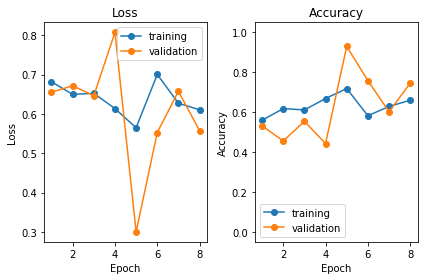


Test loss: 0.301


In [30]:
# plot training/validation loss and accuracy
plot_loss_acc(history4)
    
# test results after restoring best weights
loss4 = model4.evaluate(X_test_lstm2, y_test_lstm2, batch_size=batch_size, verbose=0)
print('\nTest loss: {:.3f}'.format(loss4[0]))

In [31]:
# evaluate model using confusion matrix-derived metrics
y_pred4 = model4.predict_classes(X_test_lstm2)
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred4)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred4).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred4))


Confusion Matrix:
[[292   1]
 [ 21   0]]

TP, TN, FP, FN: 0 , 292 , 1 , 21

Classification report:
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96       293
         1.0       0.00      0.00      0.00        21

    accuracy                           0.93       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.87      0.93      0.90       314



##### Second, try using 20 selected features, again assuming that selected features are an ordered sequence

In [32]:
# restructure data in (samples, timesteps=features, features=1) for RNN/LSTM
# use 20 selected features, same as above
X_train_lstm2 = X_train_f.values.reshape(X_train_f.shape[0], X_train_f.shape[1], 1)
y_train_lstm2 = y_train_res.values.reshape(y_train_res.shape[0], 1, 1)
X_test_lstm2 = X_test_f.values.reshape(X_test_f.shape[0], X_test_f.shape[1], 1)
y_test_lstm2 = y_test.values.reshape(y_test.shape[0], 1, 1)

In [33]:
# construct model
model5 = Sequential()
model5.add(LSTM(64, input_shape=(X_train_lstm2.shape[1], X_train_lstm2.shape[2]), return_sequences=False))
model5.add(Dense(8))
model5.add(Dense(1, activation='sigmoid'))
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
print(model5.summary())

history5 = model5.fit(X_train_lstm2, y_train_lstm2, batch_size=batch_size, epochs=epochs,
                      validation_data=(X_test_lstm2, y_test_lstm2), callbacks=cb_loss)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________
None
Train on 2340 samples, validate on 314 samples
Epoch 1/50
2340/2340 [==============================] - 3s 1ms/sample - loss: 0.6365 - accuracy: 0.6457 - val_loss: 0.5896 - val_accuracy: 0.6274
Epoch 2/50
2340/2340 [==============================] - 1s 279us/sample - loss: 0.6030 - accuracy: 0.6662 - val_loss: 0.5859 - val_accuracy: 0.5828
Epoch 3/50
2340/2340 [============

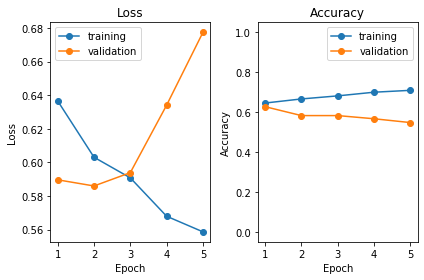


Test loss: 0.586


In [34]:
# plot training/validation loss and accuracy
plot_loss_acc(history5)
    
# test results after restoring best weights
loss5 = model5.evaluate(X_test_lstm2, y_test_lstm2, batch_size=batch_size, verbose=0)
print('\nTest loss: {:.3f}'.format(loss5[0]))

In [35]:
# evaluate model using confusion matrix-derived metrics
y_pred5 = model5.predict_classes(X_test_lstm2)
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred5)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred5).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred5))


Confusion Matrix:
[[169 124]
 [  7  14]]

TP, TN, FP, FN: 14 , 169 , 124 , 7

Classification report:
              precision    recall  f1-score   support

         0.0       0.96      0.58      0.72       293
         1.0       0.10      0.67      0.18        21

    accuracy                           0.58       314
   macro avg       0.53      0.62      0.45       314
weighted avg       0.90      0.58      0.68       314



##### 4. Summarize your findings with examples. Explain what the manufacturer should focus on to optimize the diaper manufacturing process.

In [36]:
# compare model results
precision1, recall1, fscore1, support1 = precision_recall_fscore_support(y_test, y_pred1)
accuracy1 = accuracy_score(y_test, y_pred1)
precision2, recall2, fscore2, support2 = precision_recall_fscore_support(y_test, y_pred2)
accuracy2 = accuracy_score(y_test, y_pred2)
precision3, recall3, fscore3, support3 = precision_recall_fscore_support(y_test, y_pred3)
accuracy3 = accuracy_score(y_test, y_pred3)
precision4, recall4, fscore4, support4 = precision_recall_fscore_support(y_test, y_pred4)
accuracy4 = accuracy_score(y_test, y_pred4)
precision5, recall5, fscore5, support5 = precision_recall_fscore_support(y_test, y_pred5)
accuracy5 = accuracy_score(y_test, y_pred5)

# organize into display df
results = pd.DataFrame({'Model 1/Simple ANN': np.round([precision1[1], recall1[1], fscore1[1], accuracy1],3),
                        'Model 2/Deeper ANN': np.around([precision2[1], recall2[1], fscore2[1], accuracy2],3),
                        'Model 3/LSTM (time=1, features=20)': np.round([precision3[1], recall3[1], fscore3[1], accuracy3],3),
                        'Model 4/LSTM (time=435, features=1)': np.round([precision4[1], recall4[1], fscore4[1], accuracy4],3),
                        'Model 5/LSTM (time=20, features=1)': np.round([precision5[1], recall5[1], fscore5[1], accuracy5],3)
                        },
                       index=['Precision', 'Recall', 'f1-score', 'Overall accuracy'])
results.T

,Precision,Recall,f1-score,Overall accuracy
Model 1/Simple ANN,0.130,0.619,0.215,0.697
Model 2/Deeper ANN,0.152,0.333,0.209,0.831
"Model 3/LSTM (time=1, features=20)",0.152,0.333,0.209,0.831
"Model 4/LSTM (time=435, features=1)",0.000,0.000,0.000,0.930
"Model 5/LSTM (time=20, features=1)",0.101,0.667,0.176,0.583


##### Summary of findings:  
<ul>
        <li>As ANNs are stochastic, the following findings are based on the present run</li>
    <li>20 selected features by ANOVA F-value were used unless otherwise noted. This feature set worked well in the previous Milestone and using the same feature set enables a more direct comparison with previous results</li>
    <p>
    <li>The simplest ANN with 1 input layer and 1 output layer produced a similar (if not higher) Class 1 recall compared to the deeper ANN and LSTM models tested here (and the decision tree, random forest, and SVM models built in the previous Milestone, which had Class 1 recall of ~25-40%)</li>
    <li>However, the simplest ANN produced a relatively low overall accuracy (due to high number of false positives) compared to the deeper ANN and LSTM models here (and the traditional ML models in the previous Milestone, which had accuracy of 80-90%)</li>
    <li>Thus, the simplest ANN may be adequate in detecting faulty products at a cost of high false positives</li>
    <p>
    <li>As constructed here, the DNN (or deeper ANN) model produced higher accuracy compared to the simplest ANN, but at a cost of lower Class 1 recall. The DNN produced very similar performance to the tuned decision tree, random forest, and SVM models from the previous Milestone in terms of Class 1 recall, Class 1 f1-score, and overall accuracy, which could be considered a good result, given the relatively small size of the dataset (~1600 observations total)</li>
    <p>
    <li>While the dataset had timestamps, the timesteps were not constant. Two approaches were used to build a RNN/LSTM model:
    <ul>
        <li>First, the data was restructured with a single timestep. The resultant LSTM model produced very similar results compared to the DNN model above in terms of Class 1 recall, f1-score, and accuracy</li>
        <li>Second, the data was restructured with multiple timesteps, using features as timesteps and a single feature. This approach assumes that the order of the feature columns is a sequence that may affect the label. Two feature sets were used:
            <ul>
                <li>Using all features after preprocessing (435): Class 1 recall was very low compared to all other models. In this particular run there were no true positives and the validation loss fluctuated</li>
                <li>Using the same 20-feature feature set as other models, results were similar to the simplest ANN (but both Class 1 f1-score and overall accuracy were lower)</li>
            </ul></li>
        </ul>
        </li>
        <li>Overall, restructuring the data using features as timestamps did not work well, suggesting that the order of features (i.e. sensor readings) may not inform the label</li>
</ul>


##### Recommendations:
Coming back to the diaper manufacturing problem,
<ul>
    <li>If false positives are an acceptable cost, and the priority is to identify as many faulty products as possible (for example to remove them early from downstream processes, thereby saving time and resources), the simplest ANN outperforms the other NN models here and the traditional ML models in the previous Milestone and could be deployed for this purpose</li>
    <li>Traditional ML models appear to be sufficient in predicting faulty products given the current number of samples (~1600 total observations) and selected features. ANN models do not appear to provide a significant advantage at this time (although their architecture and hyperparameters could be futher tuned)</li>
</ul>